In [1]:
import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator
from preprocess import preProcessData
import pandas as pd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
point_cloud_location = "/home/chris/Code/PointClouds/data/FLIPscans/Bendy/Bendy_1/scan1_Part1.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

mesh = o3d.io.read_triangle_mesh("/home/chris/Code/PointClouds/data/FLIPscans/Bendy/BendyCAD.STL")
mesh.compute_vertex_normals()

TriangleMesh with 4156 points and 2104 triangles.

In [3]:
# Preprocess the point cloud
pcd, average_density, cad_pcd = preProcessData(pcd, mesh, x_rotation=110, y_rotation=0, z_rotation=90)
pcd_points = np.asarray(pcd.points)
pcd_tree = o3d.geometry.KDTreeFlann(pcd)
# Detect planes, intersections, and anchor points
segment_models, segments, segment_indices, main_surface_idx = util.multiOrderRansacAdvanced(pcd, pt_to_plane_dist=0.5, verbose=True, visualize=False)
intersection_lines = util.findIntersectionLinesLeastSquares(segment_models, main_surface_idx)
segment_models = util.flip_normals_by_bend_orientation(segment_models, intersection_lines, segments, main_surface_idx, pcd_tree, search_radius=0.8, verbose=False)
angles_rad = util.findAnglesBetweenPlanes(segment_models, main_surface_idx)
anchor_points = util.findAnchorPoints(segment_models, segments, intersection_lines, main_surface_idx)

sample_dist = 0.3
aggregation_range = 7
eigen_threshold = 0.06
angle_threshold = 0.06
radius = 2
bend_length_calculator = BendLengthCalculator(pcd, anchor_points, intersection_lines, eigen_threshold, angle_threshold, aggregation_range, sample_dist, radius)
bend_edges = bend_length_calculator.compute_bend_lengths()


Identifying main plane
Clustering remaining points
Found 20 disconnected clusters
Fitting planes to remaining clusters and filtering


In [4]:
# util.draw_normal_arrows_with_geometry(segment_models, segments, main_surface_idx, random_flip=False)

In [5]:
# util.drawBendEdgesWithCylinders(pcd, bend_edges)

In [6]:
# Calculate per point normal variance and 'core' points
all_normals, pointwise_variance = util.calculatePointwiseNormalVariance(pcd, pca_radius=2, variance_radius=1.15, verbose=False)

In [7]:
core_indices = util.getCorePoints(pointwise_variance)
clusters = util.growRegionsAroundIntersections(anchor_points, core_indices, pointwise_variance, pcd_points, bend_edges, variance_percentile=70)
print("Number of clusters found: ", len(clusters))

Number of clusters found:  14


In [8]:
cluster_derivatives = {}
cluster_derivatives_for_vis = {}
bend_data = {}

for cluster_id, cluster in clusters.items():
    cluster_indices = np.array([idx for idx in cluster])
    points = pcd_points[cluster_indices]
    print(f'Cluster {cluster_id} - length of points: {len(cluster_indices)}')

    normals = all_normals[cluster_indices]
    derivatives = util.calculate_normal_derivatives(normals, points, radius=2, verbose=False)

    cluster_derivatives[cluster_id] = derivatives
    cluster_derivatives_for_vis[cluster_id] = list(zip(points, derivatives))

    if cluster_id in intersection_lines and cluster_id in bend_edges:
        bend_data[cluster_id] = {
            "intersection_line": intersection_lines[cluster_id],
            "bend_edges": bend_edges[cluster_id],
            "cluster_points": points,
            "cluster_derivatives": derivatives,
            "cluster_derivatives_for_vis": cluster_derivatives_for_vis[cluster_id],
            "anchor_points": anchor_points[cluster_id],
        }

Cluster 1 - length of points: 22542
Cluster 2 - length of points: 2208
Cluster 3 - length of points: 2370
Cluster 4 - length of points: 2180
Cluster 5 - length of points: 1890
Cluster 6 - length of points: 2191
Cluster 7 - length of points: 1977
Cluster 8 - length of points: 2213
Cluster 9 - length of points: 2045
Cluster 10 - length of points: 6195
Cluster 11 - length of points: 2168
Cluster 12 - length of points: 2115
Cluster 13 - length of points: 2180
Cluster 14 - length of points: 2573


In [9]:
class ArcLengthCalculator:
    def __init__(self, pcd, bend_id, intersection_line, bend_edges, bend_cluster_points, cluster_derivatives, all_normals, segment_indices, intersection_step_size=0.4, derivative_step_size=0.01, radius=0.5):
        self.pcd = pcd
        self.points = np.asarray(pcd.points)

        if len(pcd.points) != len(all_normals):
            raise ValueError(f"Mismatch: {len(pcd.points)} points in PCD, but {len(all_normals)} normals loaded. "
                     "Make sure the point cloud is preprocessed the same way.")
        else:
            print(f"Loaded {len(all_normals)} normals for {len(pcd.points)} points in PCD. Proceeding.")
        
        self.bend_id = bend_id
        self.intersection_line = intersection_line
        self.bend_cluster_points = bend_cluster_points
        self.bend_cluster_derivatives = cluster_derivatives
        self.bend_cluster_kdtree = cKDTree(self.bend_cluster_points)
        self.pcd_kdtree = cKDTree(self.points)
        self.start_point, self.end_point = map(np.array, bend_edges)
        self.intersection_step_size = intersection_step_size
        self.derivative_step_size = derivative_step_size
        self.all_normals = all_normals
        self.segment_indices = segment_indices
        self.radius = 1.2
        self.intersection_it = 0
        self.derivative_it = 0
        self.is_moving_forward = True

        # self.pcd.paint_uniform_color([0.6, 0.6, 0.6])
        # self.vis = o3d.visualization.Visualizer()
        # self.vis.create_window("ArcLengthCalculator")
        # self.vis.add_geometry(self.pcd)

        self.plane_dominant_bins = {}
        self.plane_dominant_bins[0] = self.get_dominant_bin_ranges(
                self.all_normals[self.segment_indices[0]],
                bin_size=1
            )
        
        self.plane_dominant_bins[bend_id] = self.get_dominant_bin_ranges(
                self.all_normals[self.segment_indices[bend_id]],
                bin_size=1
            )

    def plot_histogram_with_dominant_bins(self, angles, bin_edges, dominant_ranges, title, color):
        import matplotlib.pyplot as plt
        counts, edges, bars = plt.hist(angles, bins=bin_edges, color=color, edgecolor='black')
        # for i, bar in enumerate(bars):
        #     bin_start = edges[i]
        #     bin_end = edges[i+1]
        #     for dom_start, dom_end in dominant_ranges:
        #         if np.isclose(bin_start, dom_start, atol=1e-6) and np.isclose(bin_end, dom_end, atol=1e-6):
        #             bar.set_color('green')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def get_dominant_bin_ranges(self, normals, top_k=4, bin_size=0.4):
        dominant_bins = {}

        # Azimuth
        azimuth = np.degrees(np.arctan2(normals[:, 1], normals[:, 0]))
        az_hist, az_edges = np.histogram(azimuth, bins=np.arange(-180, 180 + bin_size, bin_size))
        top_az_indices = np.argsort(az_hist)[-top_k:]

        az_ranges = []
        for idx in top_az_indices:
            az_ranges.append((az_edges[idx], az_edges[idx + 1]))

        # Zenith
        zenith = np.degrees(np.arccos(np.clip(normals[:, 2], -1, 1)))
        zen_hist, zen_edges = np.histogram(zenith, bins=np.arange(0, 180 + bin_size, bin_size))
        top_zen_indices = np.argsort(zen_hist)[-top_k:]

        zen_ranges = []
        for idx in top_zen_indices:
            zen_ranges.append((zen_edges[idx], zen_edges[idx + 1]))

        dominant_bins["azimuth"] = az_ranges
        dominant_bins["zenith"] = zen_ranges

        # # Optional: Visualize
        # self.plot_histogram_with_dominant_bins(azimuth, az_edges, az_ranges, "Azimuth Histogram", color='skyblue')
        # self.plot_histogram_with_dominant_bins(zenith, zen_edges, zen_ranges, "Zenith Histogram", color='salmon')

        return dominant_bins

    def is_normal_in_any_bin(self, normal, bin_ranges, mode):
        if mode == "azimuth":
            angle = (np.degrees(np.arctan2(normal[1], normal[0])) + 360) % 360
        elif mode == "zenith":
            angle = np.degrees(np.arccos(np.clip(normal[2], -1, 1)))
        else:
            raise ValueError("Invalid mode: choose 'azimuth' or 'zenith'")
        
        #print(f"Angle: {angle} degrees")
        #print(f"Bin ranges: {bin_ranges}")
        for start, end in bin_ranges:
            start = (start + 360) % 360
            end = (end + 360) % 360
            if self.angle_in_range(angle, start, end):
                return True
        return False
    
    def angle_in_range(self, angle, start, end):
        """Checks if angle (in degrees) is inside [start, end], handling wrap-around."""
        angle = (angle + 360) % 360
        start = (start + 360) % 360
        end = (end + 360) % 360
        if start <= end:
            return start <= angle <= end
        else:
            return angle >= start or angle <= end
    
    def check_plane_alignment(self, normal):
        result = {}

        zenith_angle = np.degrees(np.arccos(np.clip(normal[2], -1, 1)))

        for plane_id in [0, self.bend_id]:
            bins = self.plane_dominant_bins[plane_id]
            az_bins = bins.get("azimuth", [])
            zen_bins = bins.get("zenith", [])

            # Always check zenith
            zen_match = self.is_normal_in_any_bin(normal, zen_bins, "zenith") if zen_bins else True

            # Only check azimuth if zenith is not ~0 or ~180
            if 2 < zenith_angle < 178:
                az_match = self.is_normal_in_any_bin(normal, az_bins, "azimuth") if az_bins else True
            else:
                az_match = True  # skip azimuth check for vertical normals

            result[plane_id] = az_match and zen_match

        return result
    
    def find_hemisphere_normal(self, neighborhood_points):
        mean = np.mean(neighborhood_points, axis=0)
        centered = neighborhood_points - mean
        cov = np.cov(centered.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        eig_vecs = eig_vecs[:, np.argsort(eig_vals)]  # ascending order

        pca_normal = eig_vecs[:, 0]  # Smallest eigenvalue → normal direction
        return pca_normal
    
    def align_normals(self, reference_normal, neighbor_directions):
        aligned_normals = np.array(neighbor_directions)
        
        # Check dot product: If negative, flip the normal
        for i in range(len(aligned_normals)):
            if np.dot(reference_normal, aligned_normals[i]) < 0:
                aligned_normals[i] = -aligned_normals[i]

        return aligned_normals

    def compute_piecewise_arc_length(self, points):
        return np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))

    def hug_surface(self, last_bend_point, direction_vector): 
        # 1. Find k-NN from the bend cluster (or pcd, if more stable)
        neighbor_indices = self.bend_cluster_kdtree.query(last_bend_point, k=15)[1]
        neighbor_points = self.bend_cluster_points[neighbor_indices]

        # 2. Fit a PCA plane
        mean = np.mean(neighbor_points, axis=0)
        centered = neighbor_points - mean
        cov = np.cov(centered.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        eig_vecs = eig_vecs[:, np.argsort(eig_vals)]
        pca_normal = eig_vecs[:, 0]  # Normal to the surface

        # Flip the normal if it's facing the wrong way
        vec_to_point = last_bend_point - mean
        if np.dot(vec_to_point, pca_normal) < 0:
            pca_normal = -pca_normal

        # 3. Project the raw point onto the PCA plane
        distance = np.dot(vec_to_point, pca_normal)
        projected_point = last_bend_point - distance * pca_normal

        # 4. Constrain the correction to be perpendicular to the derivative direction
        correction_vec = projected_point - last_bend_point
        perp_component = correction_vec - np.dot(correction_vec, direction_vector) * direction_vector

        # 5. Apply only the perpendicular correction
        final_point = last_bend_point + perp_component

        return final_point
    
    def find_bend_end(self, bend_point, derivate_direction):
        initial_direction = derivate_direction.copy()
        path_points = [bend_point.copy()]
        i=0
        projected_bend_point = bend_point.copy()
        total_arc_length = 0
        while True:
            neighbor_all_indices = self.pcd_kdtree.query_ball_point(bend_point, self.radius)
            if len(neighbor_all_indices) > 10 and i<170:
                # Separate neighbors by hemisphere
                neighbor_points = self.points[neighbor_all_indices]
                # FULL HEMISPHERE
                # vectors = neighbor_points - bend_point
                # dot_products = vectors @ derivate_direction
                # forward_mask = dot_products > 0
                # forward_indices = np.array(neighbor_all_indices)[forward_mask]
                # #print(f"Forward indices: {forward_indices}")
                # forward_points = self.points[forward_indices]
                # pca_normal = self.find_hemisphere_normal(forward_points)

                # SLAB FORWARD STRUCTURE
                vectors = neighbor_points - bend_point
                dot_products = vectors @ derivate_direction
                epsilon = 0.4
                mask_1 = np.abs(dot_products) < epsilon
                mask_2 = dot_products > 0
                final_mask = mask_1 & mask_2
                #final_mask = mask_1
                forward_indices = np.array(neighbor_all_indices)[final_mask]
                forward_points = self.points[forward_indices]
                try:
                    pca_normal = self.find_hemisphere_normal(forward_points)
                except np.linalg.LinAlgError:
                    print(f"[WARN] PCA failed at iteration {i} for bend ID {self.bend_id} (LinAlgError)")
                    total_arc_length = self.compute_piecewise_arc_length(np.array(path_points))
                    return projected_bend_point, total_arc_length
                except Exception as e:
                    print(f"[WARN] PCA failed at iteration {i} for bend ID {self.bend_id}: {e}")
                    total_arc_length = self.compute_piecewise_arc_length(np.array(path_points))
                    return projected_bend_point, total_arc_length

                bend_global_idx = self.pcd_kdtree.query(bend_point)[1]
                original_normal = self.all_normals[bend_global_idx]

                if np.dot(pca_normal, original_normal) < 0:
                    pca_normal = -pca_normal

                alignment = self.check_plane_alignment(pca_normal)
                #print(f"Alignment: Plane 0 = {alignment[0]}, Plane {self.bend_id} = {alignment[self.bend_id]}", flush=True)
                if alignment[0] or alignment[self.bend_id]:
                    #print("Found alignment in direction", derivate_direction)
                    total_arc_length = self.compute_piecewise_arc_length(np.array(path_points))
                    return projected_bend_point, total_arc_length
                neighbor_bend_indices = self.bend_cluster_kdtree.query_ball_point(bend_point, self.radius)
                if len(neighbor_bend_indices) > 5:
                    neighbor_derivatives = self.bend_cluster_derivatives[neighbor_bend_indices]
                    aligned_neighbor_derivatives = self.align_normals(initial_direction, neighbor_derivatives)
                    derivate_direction = np.mean(aligned_neighbor_derivatives, axis=0)
                    derivate_direction /= np.linalg.norm(derivate_direction)
                bend_point = bend_point + self.derivative_step_size*derivate_direction
                projected_bend_point = self.hug_surface(bend_point, derivate_direction)
                path_points.append(projected_bend_point.copy())
                bend_point = projected_bend_point.copy()
                #print(f'i = {i}')
                i += 1
            else:
                total_arc_length = self.compute_piecewise_arc_length(np.array(path_points))
                return projected_bend_point, total_arc_length
            
    def calculate_arc_length(self):
        # At the top of the function
        results_table = []
        distances = []
        direction_vector = self.intersection_line[0] / np.linalg.norm(self.intersection_line[0])
        to_end = self.end_point - self.start_point
        if np.dot(direction_vector, to_end) < 0:
            direction_vector *= -1  # Flip if it's pointing toward the wrong side
        
        offset = self.radius
        sampled_point = self.start_point + offset * direction_vector
        end_points_forward = []
        end_points_backward = []
        while np.linalg.norm(sampled_point - self.start_point) < np.linalg.norm(self.end_point - self.start_point) - offset:
            # Sample next point
            sampled_point += self.intersection_step_size * direction_vector
            # Get point closest to the sampled point
            idx = self.bend_cluster_kdtree.query(sampled_point)[1]
            base = self.bend_cluster_points[idx]
            # Get the average derivative of the bend in the neighborhood
            neighbor_bend_indices = self.bend_cluster_kdtree.query_ball_point(base, self.radius)
            neighbor_derivatives = self.bend_cluster_derivatives[neighbor_bend_indices]
            aligned_neighbor_derivatives = self.align_normals(neighbor_derivatives[0], neighbor_derivatives)
            derivate_reference = np.mean(aligned_neighbor_derivatives, axis=0)
            derivate_reference /= np.linalg.norm(derivate_reference)

            # Calculate bend end point in forward direction
            end_point_forward, first_half_distance = self.find_bend_end(base, derivate_reference)
            
            # Calculate bend end point in backward direction
            end_point_backward, second_half_distance = self.find_bend_end(base, -derivate_reference)

            end_points_forward.append(end_point_forward)
            end_points_backward.append(end_point_backward)

            total_distance = first_half_distance + second_half_distance
            distances.append(total_distance)
            results_table.append({
                "Sample Index": len(results_table),
                "Base XYZ": base,
                "Arc Length Forward": first_half_distance,
                "Arc Length Backward": second_half_distance,
                "Total Arc Length": total_distance
            })
            print(f'arc length: {total_distance}')

        df = pd.DataFrame(results_table)
        if df.empty:
            print(f"[WARN] No samples processed for bend ID {self.bend_id}")
            print(f"start: {self.start_point}, end: {self.end_point}, intersection line length: {np.linalg.norm(self.end_point - self.start_point):.3f}")
            return df
        return df

    # def run(self):
    #     self.vis.run()
    #     self.vis.destroy_window()

In [10]:
import itertools

def is_within_bend_subsegment(point, start_point, end_point, sub_start_ratio, sub_end_ratio):
    """
    Checks if a point lies within a specific subsegment along the bend line.

    Args:
        point (np.ndarray): The 3D point to test.
        start_point (np.ndarray): The global start of the bend line.
        end_point (np.ndarray): The global end of the bend line.
        sub_start_ratio (float): Start of subsegment as a fraction (e.g., 0.0 to 1.0).
        sub_end_ratio (float): End of subsegment as a fraction (e.g., 0.33 to 0.66).

    Returns:
        bool: True if point lies within the specified subsegment, False otherwise.
    """
    point = np.array(point)
    start_point = np.array(start_point)
    end_point = np.array(end_point)

    bend_vector = end_point - start_point
    bend_length = np.linalg.norm(bend_vector)
    bend_direction = bend_vector / bend_length

    # Define subsegment endpoints
    sub_start = start_point + sub_start_ratio * bend_length * bend_direction
    sub_end = start_point + sub_end_ratio * bend_length * bend_direction

    # Check if point lies between sub_start and sub_end
    point_vector = point - sub_start
    sub_segment_vector = sub_end - sub_start
    proj = np.dot(point_vector, sub_segment_vector)
    return 0 <= proj <= np.dot(sub_segment_vector, sub_segment_vector)

def get_section_points(pcd, segment_indices, section_ranges):
    """
    Filters points from a segment into subregions along the bend.

    Args:
        pcd (o3d.geometry.PointCloud): The full point cloud.
        segment_indices (list[int]): Indices of the points belonging to the inclined plane.
        section_ranges (list[tuple[np.ndarray, np.ndarray]]): List of (start, end) for each bend section.

    Returns:
        section_points_list (list[np.ndarray]): List of Nx3 arrays, one per section.
    """
    segment_points = np.asarray(pcd.points)[segment_indices]
    section_points_list = [[] for _ in range(len(section_ranges))]

    for pt in segment_points:
        for i, (sec_start, sec_end) in enumerate(section_ranges):
            if is_within_bend_subsegment(pt, sec_start, sec_end, 0.0, 1.0):  # full segment range
                section_points_list[i].append(pt)
                break  # avoid double assignment

    # Convert lists to np arrays
    section_points_list = [np.array(pts) for pts in section_points_list]
    return section_points_list

def fit_plane_normal_pca(points):
    """
    Fits a plane to a set of points using PCA and returns the normal.

    Args:
        points (np.ndarray): Nx3 array of 3D points.

    Returns:
        normal (np.ndarray): The normal vector of the best-fit plane (unit length).
        valid (bool): Whether the fit was successful (i.e., enough points).
    """
    if len(points) < 3:
        return None, False  # Not enough points for PCA

    # Center the points
    mu = np.mean(points, axis=0)
    centered = points - mu

    # Covariance matrix and eigendecomposition
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Smallest eigenvalue → normal direction
    normal = eigvecs[:, 0]
    normal /= np.linalg.norm(normal)

    return normal, True

def compute_mean_pairwise_angle(normals):
    """
    Computes the mean angle (in degrees) between all pairs of normals.

    Args:
        normals (list[np.ndarray]): List of 3D unit vectors.

    Returns:
        float: Mean pairwise angle in degrees.
    """
    angles = []
    for n1, n2 in itertools.combinations(normals, 2):
        cos_angle = np.clip(np.dot(n1, n2), -1.0, 1.0)
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        angles.append(angle_deg)
    
    return np.mean(angles) if angles else None

def compute_cosine_uniformity(normals):
    """
    Computes 1 - mean cosine similarity to the average normal.
    Lower value = better uniformity.

    Args:
        normals (list[np.ndarray]): List of unit normal vectors.

    Returns:
        float: 1 - mean cosine similarity to the average normal.
    """
    if len(normals) < 2:
        return None

    avg_normal = np.mean(normals, axis=0)
    avg_normal /= np.linalg.norm(avg_normal)

    cos_sims = [abs(np.dot(n, avg_normal)) for n in normals]
    return 1 - np.mean(cos_sims)

def compute_angle_uniformity(
    pcd,
    segment_indices,
    intersection_line,
    start_point,
    end_point,
    global_plane_normal,
    num_sections=3,
    search_radius=2.0
):
    """
    Computes angle uniformity along a bend by splitting the segment into parts and comparing refitted plane normals.
    
    Args:
        pcd: Open3D point cloud object.
        segment_indices: list or np.array of point indices belonging to the inclined plane.
        intersection_line: tuple (direction_vector, point_on_line)
        start_point, end_point: 3D coordinates marking the bend limits.
        num_sections: Number of sections to split the bend into (default=3).
        search_radius: Radius for finding nearby points to each section center.

    Returns:
        angle_uniformity: float, mean pairwise angle between normals in degrees.
    """
    
    direction_vector = end_point - start_point
    direction_vector /= np.linalg.norm(direction_vector)  # Normalize and ensure forward direction
    section_length = np.linalg.norm(end_point - start_point) / num_sections

    section_ranges = []
    for i in range(num_sections):
        section_start = start_point + i * section_length * direction_vector
        section_end = start_point + (i + 1) * section_length * direction_vector
        section_ranges.append((section_start, section_end))

    section_points = get_section_points(pcd, segment_indices, section_ranges)

    normals = []
    for section in section_points:
        normal, ok = fit_plane_normal_pca(section)
        if ok:
            # Flip if not aligned
            if np.dot(normal, global_plane_normal) < 0:
                normal = -normal
            normals.append(normal)

    if len(normals) >= 2:
        angle_uniformity = compute_mean_pairwise_angle(normals)
        cosine_uniformity = compute_cosine_uniformity(normals)
    else:
        angle_uniformity = None
        cosine_uniformity = None

    return angle_uniformity, cosine_uniformity

In [11]:
class GaussMapVisualizer:
    def __init__(self, pcd, all_normals, standard_deviations, clusters, radius, cluster_derivatives=None):
        self.pcd = pcd
        self.points = np.asarray(pcd.points)
        self.pcd.paint_uniform_color([0.6, 0.6, 0.6])
        self.kdtree = cKDTree(self.points)
        self.plane_directions = all_normals
        self.clusters = clusters
        self.radius = radius
        self.standard_deviations = standard_deviations
        low, high = np.percentile(self.standard_deviations, [60, 100])
        self.core_indices = np.where((self.standard_deviations > low) & (self.standard_deviations <= high))[0]
        #print(f"Found {len(self.core_indices)} core points out of {len(self.pcd.points)} total points.")
        self.reference_normal = None
        self.heatmap_mode = False  # Default mode: Bend visualization
        self.use_global_percentile = False
        self.current_index = 0
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window("GaussMapVisualizer")
        self.current_variance_percentile = 65

        # **Register callback to toggle heatmap mode**
        self.vis.register_key_callback(265, self.toggle_global_percentile)
        self.vis.register_key_callback(263, self.toggle_heatmap)
        self.vis.register_key_callback(262, self.next_neighborhood)
        self.vis.register_key_callback(264, self.show_random_core_point)
        self.vis.add_geometry(self.pcd)
        self.cluster_derivatives = cluster_derivatives
        self.apply_variation_heatmap(self.clusters)
        if self.cluster_derivatives is None:
            self.calculate_normal_derivatives()
        else:
            self.load_cluster_derivatives()
        self.derivative_visible = True
        self.vis.register_key_callback(ord("D"), self.toggle_derivatives)
        self.vis.register_key_callback(ord("M"), self.increase_variance_threshold)  # Up arrow
        self.vis.register_key_callback(ord("L"), self.decrease_variance_threshold)  # Down arrow
        self._update_neighborhood()

    def toggle_derivatives(self, vis):
        if hasattr(self, "derivative_lines"):
            if self.derivative_visible:
                self.vis.remove_geometry(self.derivative_lines)
                print("Normal derivatives hidden.")
            else:
                self.vis.add_geometry(self.derivative_lines)
                print("Normal derivatives shown.")
            self.derivative_visible = not self.derivative_visible
            vis.update_geometry(self.pcd)
            
    def toggle_heatmap(self, vis):
        self.heatmap_mode = not self.heatmap_mode  # Flip mode
        print(f'self.heatmap_mode: {self.heatmap_mode}')

        if self.heatmap_mode:
            self.apply_full_heatmap()
            print("Switched to Full Point Cloud Heatmap Mode.")
        else:
            self.apply_variation_heatmap(self.clusters)
            print("Switched to Bends-Only Mode.")

        vis.update_geometry(self.pcd)
        # vis.poll_events()
        # vis.update_renderer()

    def apply_full_heatmap(self):
        """ Apply full heatmap coloring based on normal variance. """
        colors = self.normalize_variation_colors(self.standard_deviations)
        self.pcd.colors = o3d.utility.Vector3dVector(colors)

    def get_nearest_neighbor_directions(self, point, kdtree, pcd, plane_directions, radius=2):
        """ Get the directions of the k nearest neighbors to a given point. """
        idx = kdtree.query_ball_point(point, radius)
        nearest_points = np.asarray(pcd.points)[idx]
        nearest_directions = np.asarray(plane_directions)[idx]
        return idx, nearest_points, nearest_directions

    def increase_variance_threshold(self, vis):
        self.current_variance_percentile = min(100, self.current_variance_percentile + 1)
        print(f"Increased threshold to {self.current_variance_percentile} percentile")
        self.apply_thresholded_heatmap(self.clusters)
        vis.update_geometry(self.pcd)

    def decrease_variance_threshold(self, vis):
        self.current_variance_percentile = max(0, self.current_variance_percentile - 1)
        print(f"Decreased threshold to {self.current_variance_percentile} percentile")
        self.apply_thresholded_heatmap(self.clusters)
        vis.update_geometry(self.pcd)
    
    def create_normal_lines(self, neighbor_points, neighbor_directions, scale=0.2):
        """ Create line segments for the normal directions at each point. """
        line_set = o3d.geometry.LineSet()

        start_points = np.array(neighbor_points)
        end_points = start_points + scale * np.array(neighbor_directions)
        lines = [[start_points[i], end_points[i]] for i in range(len(neighbor_points))]
        line_set.points = o3d.utility.Vector3dVector(np.concatenate(lines, axis=0))
        line_indices = [[i, i + 1] for i in range(0, len(lines) * 2, 2)]
        line_set.lines = o3d.utility.Vector2iVector(line_indices)
        line_set.colors = o3d.utility.Vector3dVector(np.tile((0, 0, 1), (len(lines), 1)))
        return line_set
    
    def align_normals(self, reference_normal, neighbor_directions):
        aligned_normals = np.array(neighbor_directions)
        
        # Check dot product: If negative, flip the normal
        for i in range(len(aligned_normals)):
            if np.dot(reference_normal, aligned_normals[i]) < 0:
                aligned_normals[i] = -aligned_normals[i]

        return aligned_normals
    
    def calculate_normal_variation(self, normals):
        mu = np.mean(normals, axis=0)
        norm = normals - mu
        cov = np.cov(norm.T)
        eig_val, _ = np.linalg.eig(cov)
        sorted_idx = np.argsort(eig_val)[::-1]
        eig_val = eig_val[sorted_idx]
        eig_val_norm = eig_val / np.sum(eig_val)
        
        return mu, eig_val_norm, cov
    
    def update_gauss_map(self, normals):
        """ Update the Gauss Map visualization with the current neighborhood's normals. """
        normals = np.array(normals)
        normals /= np.linalg.norm(normals, axis=1, keepdims=True)  # Normalize to unit sphere

        # Create figure
        plt.figure("Gauss Map", figsize=(6, 6))
        plt.clf()  # Clear previous plot
        ax = plt.subplot(111, projection="3d")

        # Plot unit sphere
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 20)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color="gray", alpha=0.3, edgecolor="none")  # Transparent sphere

        # Plot normal vectors
        for normal in normals:
            ax.quiver(0, 0, 0, normal[0], normal[1], normal[2], color="b", linewidth=1, arrow_length_ratio=0.1)

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(f"Gauss Map - Neighborhood {self.current_index}")

        plt.pause(0.1)  # Allow Matplotlib to update

    def show_random_core_point(self, vis):
        if len(self.core_indices) == 0:
            print("No core points found.")
            return

        # Pick a random core point
        self.current_index = random.choice(self.core_indices)

        # Visualize its neighborhood
        self._update_neighborhood()

        print(f"Showing core point {self.current_index}.")

    def compute_normal_derivative_pca(self, normals):
        """Compute dominant direction of normal variation using PCA."""
        cov = np.cov(normals.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        return eig_vecs[:, np.argmax(eig_vals)]  # Largest eigenvector = main change direction
    
    def calculate_normal_derivatives(self):
        """Compute normal derivatives for all core points and store them for visualization."""
        self.derivative_vectors = []
        self.derivative_positions = []

        for i, core_idx in enumerate(self.core_indices):
            # Get neighborhood
            print(f"Computing normal derivative {i}/{len(self.core_indices)}")
            core_point = self.points[core_idx]
            neighbor_indices = self.kdtree.query_ball_point(core_point, self.radius)

            if len(neighbor_indices) < 3:
                continue  # Skip small neighborhoods

            neighbors = self.points[neighbor_indices]
            normals = self.plane_directions[neighbor_indices]

            # Compute normal derivative
            normal_gradient = self.compute_normal_derivative_pca(normals)  # or self.compute_normal_derivative

            self.derivative_positions.append(core_point)
            self.derivative_vectors.append(normal_gradient)

        print(f"Computed {len(self.derivative_vectors)} normal derivatives.")
        self.add_normal_derivatives()

    def load_cluster_derivatives(self):
        self.derivative_vectors = []
        self.derivative_positions = []

        for cluster_id, derivatives in self.cluster_derivatives.items():
            for pos, vec in derivatives:
                self.derivative_positions.append(pos)
                self.derivative_vectors.append(vec)

        print(f"Loaded {len(self.derivative_vectors)} normal derivatives from input.")
        self.add_normal_derivatives()

    def add_normal_derivatives(self):
        """Add the precomputed normal derivative vectors to the visualization."""
        if self.derivative_vectors:
            self.derivative_lines = self.create_lines(self.derivative_positions, self.derivative_vectors, color=(1, 0, 0), scale=1.5)
            self.vis.add_geometry(self.derivative_lines)
            print(f"Added {len(self.derivative_vectors)} normal derivative vectors to the visualization.")

    def _update_neighborhood(self):
        """ Update visualization for the current neighborhood. """
        # Get the currently selected point
        query_point = np.asarray(self.pcd.points)[self.current_index]

        # Get nearest neighbors
        idx, neighbor_points, neighbor_directions = self.get_nearest_neighbor_directions(query_point, self.kdtree, self.pcd, self.plane_directions, radius=self.radius)
        if self.current_index==0:
            self.reference_normal = neighbor_directions[0]

        aligned_directions = self.align_normals(self.reference_normal, neighbor_directions)
        normal_mean, normal_variation, cov_after = self.calculate_normal_variation(aligned_directions)

        if hasattr(self, "normal_lines"):
            self.vis.remove_geometry(self.normal_lines)
        self.normal_lines = self.create_normal_lines(neighbor_points, aligned_directions, scale=2)
        self.vis.add_geometry(self.normal_lines)
        view_ctl = self.vis.get_view_control()
        lookat = query_point
        zoom = 0.080000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera

        self.update_gauss_map(aligned_directions)

        self.vis.update_geometry(self.pcd)
        print(f"Neighborhood {self.current_index}/{len(self.pcd.points)} updated", flush=True)
        #print(f'Aligned normals: {neighbor_directions}', flush=True)
        #print(f"Normal mean: {normal_mean}, Normal variation: {normal_variation}", flush=True)
        #print(f"Std Dev of Normals: {np.std(neighbor_directions, axis=0)}")
        #print(f"Condition Number of Covariance: {np.linalg.cond(cov_after)}")
        print(15*"-", flush=True)

    def next_neighborhood(self, vis):
        """ Move to the next neighborhood when right arrow key is pressed. """
        self.current_index = (self.current_index + 500) % len(self.pcd.points)
        self._update_neighborhood()
    
    def normalize_variation_colors(self, variation_values, use_global=False):
        """ 
        Normalize variation values to a colormap range.
        
        Args:
            variation_values (np.ndarray): The normal variance values.
            use_global (bool): Whether to use global percentile normalization.
        
        Returns:
            np.ndarray: RGB colors mapped from a colormap.
        """
        if use_global:
            min_val, max_val = np.percentile(self.standard_deviations, [2, 98])  # Use all points
        else:
            min_val, max_val = np.percentile(variation_values, [2, 98])  # Use local cluster

        norm_variation = (variation_values - min_val) / (max_val - min_val + 1e-6)  # Normalize to [0,1]
        colors = cm.viridis(np.clip(norm_variation, 0, 1))[:, :3]  # Extract RGB colors

        return colors
    
    def toggle_global_percentile(self, vis):
        """ Toggle between local and global percentile normalization. """
        self.use_global_percentile = not self.use_global_percentile  # Flip mode
        self.apply_variation_heatmap(self.clusters)  # Reapply colors

        mode = "Global" if self.use_global_percentile else "Local"
        print(f"Switched to {mode} Percentile Normalization.")

        vis.update_geometry(self.pcd)

    def create_lines(self, points, vectors, color=(1, 0, 0), scale=1.0):
        """Creates Open3D line geometry for visualization."""
        start_points = np.array(points)
        end_points = start_points + scale * np.array(vectors)
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(np.vstack((start_points, end_points)))
        line_indices = [[i, i + len(points)] for i in range(len(points))]
        line_set.lines = o3d.utility.Vector2iVector(line_indices)
        line_set.colors = o3d.utility.Vector3dVector([color] * len(line_indices))
        return line_set
    
    def apply_variation_heatmap(self, clusters, unclustered_color=(0.7, 0.7, 0.7)):
        """
        Colors clustered points using the heatmap and assigns a uniform color to unclustered points.

        Args:
            clusters (list of sets): List of clusters, where each set contains indices of points in a cluster.
            unclustered_color (tuple): RGB color for unclustered points (default: light gray).
        """
        num_points = len(self.points)
        colors = np.full((num_points, 3), fill_value=unclustered_color)  # Default: all points = light gray

        clustered_indices = np.array([idx for cluster in clusters.values() for idx in cluster])

        if clustered_indices.size > 0:
            clustered_variance = self.standard_deviations[clustered_indices]

            # **Use global or local percentile normalization**
            clustered_colors = self.normalize_variation_colors(clustered_variance, use_global=self.use_global_percentile)

            # **Apply heatmap colors to clustered points**
            colors[clustered_indices] = clustered_colors  

        self.pcd.colors = o3d.utility.Vector3dVector(colors)

        mode = "Global" if self.use_global_percentile else "Local"
        print(f"Applied {mode} Percentile Heatmap to Clusters.")

    def apply_thresholded_heatmap(self, clusters, unclustered_color=(0.7, 0.7, 0.7)):
        num_points = len(self.points)
        colors = np.full((num_points, 3), fill_value=unclustered_color)

        clustered_indices = np.array([idx for cluster in clusters.values() for idx in cluster])

        if clustered_indices.size > 0:
            clustered_variance = self.standard_deviations[clustered_indices]

            # Threshold based on selected percentile
            threshold = np.percentile(clustered_variance, self.current_variance_percentile)
            keep_mask = clustered_variance >= threshold
            kept_indices = clustered_indices[keep_mask]
            kept_variance = clustered_variance[keep_mask]

            # Color only the high-variance points
            kept_colors = self.normalize_variation_colors(kept_variance, use_global=self.use_global_percentile)
            colors[kept_indices] = kept_colors

        self.pcd.colors = o3d.utility.Vector3dVector(colors)
        print(f"Applied variance threshold at {self.current_variance_percentile}th percentile")


    def run(self):
        self.vis.run()  # Start the visualization loop (blocks until closed)
        self.vis.destroy_window()

In [12]:
util.draw_normal_arrows_with_geometry(segment_models, segments, main_surface_idx, random_flip=False)

In [13]:
util.drawBendEdgesWithCylinders(pcd, bend_edges)

Applied Local Percentile Heatmap to Clusters.
Loaded 54847 normal derivatives from input.
Added 54847 normal derivative vectors to the visualization.


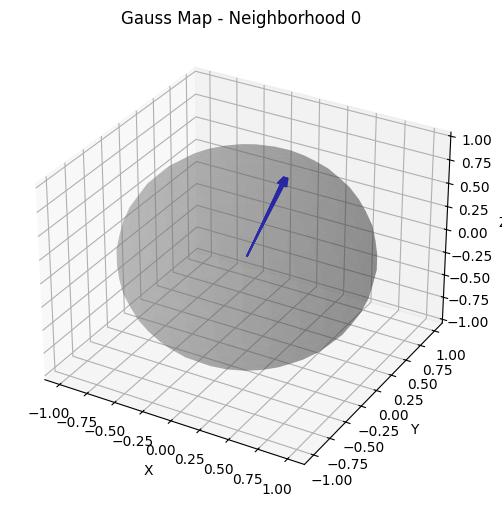

Neighborhood 0/275177 updated
---------------


In [14]:
visualizer = GaussMapVisualizer(pcd, all_normals, pointwise_variance, clusters, radius=0.5, cluster_derivatives=cluster_derivatives_for_vis)

visualizer.run()

In [15]:
# Store results as tuples
angle_results = [(k, np.degrees(v)) for k, v in angles_rad.items()]

print("\n=== Angle Between Planes (to Main Surface) ===")
for plane_id, angle_deg in angle_results:
    print(f"Plane {plane_id}: {angle_deg:.2f}°")


=== Angle Between Planes (to Main Surface) ===
Plane 1: 85.31°
Plane 2: 31.30°
Plane 3: 78.24°
Plane 4: 31.43°
Plane 5: 64.39°
Plane 6: 32.00°
Plane 7: 53.40°
Plane 8: 32.39°
Plane 9: 42.61°
Plane 10: 36.72°
Plane 11: 32.68°
Plane 12: 28.74°
Plane 13: 32.61°
Plane 14: 15.55°


In [16]:
angle_uniformity_results = []

print("\n=== Angle Uniformity Summary ===")

for plane_id, bend_edge in bend_edges.items():
    if plane_id not in segment_indices or plane_id not in intersection_lines:
        print(f"[Warning] Missing data for plane {plane_id}, skipping.")
        continue

    segment_pts = segment_indices[plane_id]
    intersection_line = intersection_lines[plane_id]
    start_point, end_point = bend_edge

    n_inclined = np.array(segment_models[plane_id][:3])
    n_inclined /= np.linalg.norm(n_inclined)

    angle_u, cosine_u = compute_angle_uniformity(
        pcd=pcd,
        segment_indices=segment_indices[plane_id],
        intersection_line=intersection_lines[plane_id],
        start_point=bend_edges[plane_id][0],
        end_point=bend_edges[plane_id][1],
        global_plane_normal=n_inclined
    )

    print(f"Plane {plane_id}: Mean Angle Diff = {angle_u:.2f}°, Cosine Uniformity = {cosine_u:.4f}")

    angle_uniformity_results.append({
        "Plane ID": plane_id,
        "Angle Uniformity (deg)": angle_u,
        "Cosine Uniformity": cosine_u
    })



=== Angle Uniformity Summary ===
Plane 1: Mean Angle Diff = 0.93°, Cosine Uniformity = 0.0000
Plane 2: Mean Angle Diff = 0.59°, Cosine Uniformity = 0.0000
Plane 3: Mean Angle Diff = 1.10°, Cosine Uniformity = 0.0001
Plane 4: Mean Angle Diff = 1.02°, Cosine Uniformity = 0.0001
Plane 5: Mean Angle Diff = 0.64°, Cosine Uniformity = 0.0000
Plane 6: Mean Angle Diff = 0.61°, Cosine Uniformity = 0.0000
Plane 7: Mean Angle Diff = 0.30°, Cosine Uniformity = 0.0000
Plane 8: Mean Angle Diff = 0.50°, Cosine Uniformity = 0.0000
Plane 9: Mean Angle Diff = 0.39°, Cosine Uniformity = 0.0000
Plane 10: Mean Angle Diff = 0.75°, Cosine Uniformity = 0.0000
Plane 11: Mean Angle Diff = 0.96°, Cosine Uniformity = 0.0001
Plane 12: Mean Angle Diff = 0.96°, Cosine Uniformity = 0.0001
Plane 13: Mean Angle Diff = 0.40°, Cosine Uniformity = 0.0000
Plane 14: Mean Angle Diff = 6.28°, Cosine Uniformity = 0.0029


In [17]:
print(f'bend ids in benddata: {bend_data.keys()}')

bend ids in benddata: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])


In [ ]:
results = []

for bend_id, bend_info in bend_data.items():
    print(f"\nProcessing bend ID: {bend_id}")
    calculator = ArcLengthCalculator(
        pcd=pcd,
        bend_id=bend_id,
        intersection_line=bend_info["intersection_line"],
        bend_edges=bend_info["bend_edges"],
        bend_cluster_points=bend_info["cluster_points"],
        cluster_derivatives=bend_info["cluster_derivatives"],
        all_normals=all_normals,
        segment_indices=segment_indices
        
    )
    df = calculator.calculate_arc_length()
    if df.empty:
        continue
    else:
        mean_arc = df["Total Arc Length"].mean()
        std_arc = df["Total Arc Length"].std()
        print(f"→ Bend {bend_id}: Mean = {mean_arc:.4f} mm | Std = {std_arc:.4f} mm")
        results.append((bend_id, mean_arc, std_arc))

# Print all results together
print("\n=== Arc Length Summary ===")
for bend_id, mean_arc, std_arc in results:
    print(f"Bend {bend_id}: Mean = {mean_arc:.4f} mm | Std = {std_arc:.4f} mm")


Processing bend ID: 1
Loaded 275177 normals for 275177 points in PCD. Proceeding.
arc length: 2.1993130317038263
arc length: 2.3342848155121434
arc length: 1.2835725375147577
arc length: 1.4072198718702917
arc length: 1.179633446021996
arc length: 1.2703943604140688
arc length: 1.2400622524646039
arc length: 1.1886574231391382
arc length: 1.1711081800531924
arc length: 1.214149954672573
arc length: 2.1136896910687817
arc length: 1.8912667187360153
arc length: 1.1602829561150982
arc length: 1.221684860064228
arc length: 1.2464046588549569
arc length: 1.171475796995247
arc length: 1.1883382396384696
arc length: 1.2616862280578531
arc length: 1.2002567051173902
arc length: 1.1530099133837057
arc length: 1.3941887840339464
arc length: 1.2020135731020831
arc length: 1.1537961274039616
arc length: 1.1743063022342737
arc length: 1.1564622615434204
arc length: 2.3056642387524984
arc length: 1.1444112016040808
arc length: 1.1870943063491826
arc length: 1.1818921601266585
arc length: 1.21944432

In [ ]:
# Visualize scan with arc length labels at anchor points
geometries = [pcd]  # Assume 'pcd' is your full registered scan point cloud
pcd.paint_uniform_color([0.6, 0.6, 0.6])  # Set color for the point cloud
for bend_id, mean_arc, std_arc in results:
    anchor = np.array(bend_data[bend_id]["anchor_points"])

    # Add sphere
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5)
    sphere.translate(anchor)
    sphere.paint_uniform_color([0, 0, 0])
    geometries.append(sphere)

    try:
        # Create text
        text_mesh = o3d.t.geometry.TriangleMesh.create_text(
            text=f"B{bend_id}: {mean_arc:.2f} mm",
            depth=5
        ).to_legacy()

        # Transform: scale and position
        transform = np.array([
            [0.1, 0,   0,   anchor[0]],
            [0,   0.1, 0,   anchor[1]],
            [0,   0,   0.1, anchor[2] + 4.0],
            [0,   0,   0,   1]
        ])
        text_mesh.transform(transform)
        text_mesh.paint_uniform_color([0.1, 0.1, 0.1])
        geometries.append(text_mesh)

    except Exception as e:
        print(f"[WARN] Could not render text for Bend {bend_id}: {e}")


# Final visualization
o3d.visualization.draw_geometries(geometries)